# Comparing Models

## Import stuff

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

## Compare model visualization

R2-score and MSE

In [ ]:
# https://matplotlib.org/1.2.1/examples/pylab_examples/errorbar_demo.html

In [ ]:
# https://stackoverflow.com/questions/22364565/python-pylab-scatter-plot-error-bars-the-error-on-each-point-is-unique

### Independet varables (X):
### Spotify API, Countries, Position, AvgStreams, AvgPosition, TextBlob, NLP

Spotify API: Acousticness, Energy, Instrumentalness, Mode, Tempo, Valence<BR />
Countries: au, ca, de, fr, gb, it, nl, us<BR />
Position: 1-200<BR />
TextBlob: Polarity, Subjectivity<BR />
NLP: CountVec / TF-IDF

**LinearRegressor**

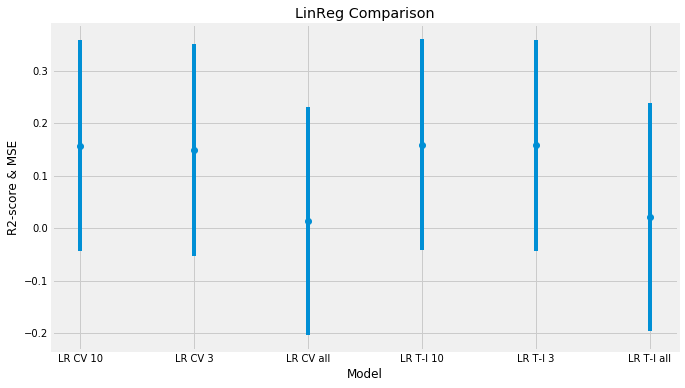

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['LR CV all', 'LR CV 10', 'LR CV 3', 'LR T-I all', 'LR T-I 10', 'LR T-I 3'] # model name
y = [0.013486410677653882, 0.15703025345048383, 0.14873571822331177, 0.021622186821517175, 0.15924513606808388,
     0.15789602776517975] # r2-score
e = [0.2179414544286909, 0.2014625390102933, 0.20245127414703298, 0.21704091246303905, 0.20119769595475592,
     0.20135905611527427] #MSE

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('LinReg Comparison');
plt.show()

**LassoRegressor**

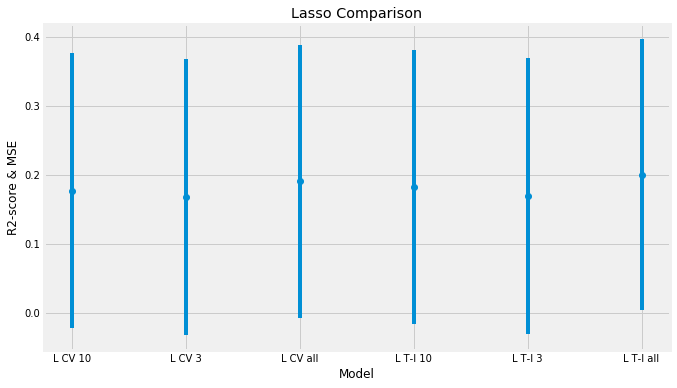

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['L CV all', 'L CV 10', 'L CV 3', 'L T-I all', 'L T-I 10', 'L T-I 3'] # model name
y = [0.19040608132068992, 0.1770206960698385, 0.1674465753925105, 0.20023665642903288, 0.18211786284966514,
     0.16874316536260703] # r2-score
e = [0.19743399228941258, 0.19905943437873008, 0.20021396415554327, 0.19623165025591427, 0.19844203423818374,
     0.20005800024972248] #MSE

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Lasso Comparison');
plt.show()

**RandomForestRegressor**

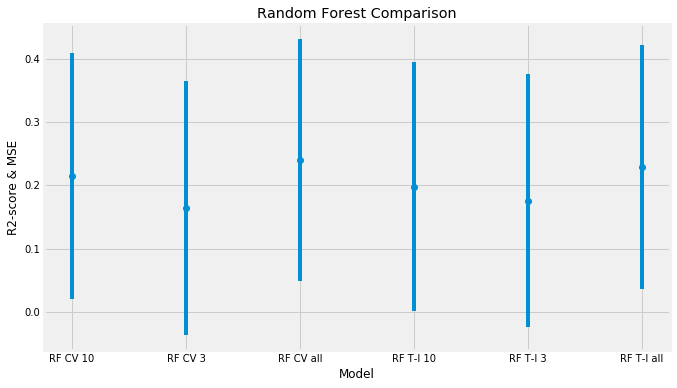

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['RF CV all', 'RF CV 10', 'RF CV 3', 'RF T-I all', 'RF T-I 10', 'RF T-I 3'] # model name
y = [0.23981061254827155, 0.2147670028572991, 0.1638699609332285, 0.22945469325352852, 0.19794165559197285,
     0.17616744455605482] # r2-score
e = [0.19131508276423695, 0.19444088066811846, 0.20064355865025515, 0.19261379965871128, 0.1965130017241746,
     0.1991625984327136] #MSE

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Random Forest Comparison');
plt.show()

**AdaBoosterRegressor+GradientBoosterRegressor**

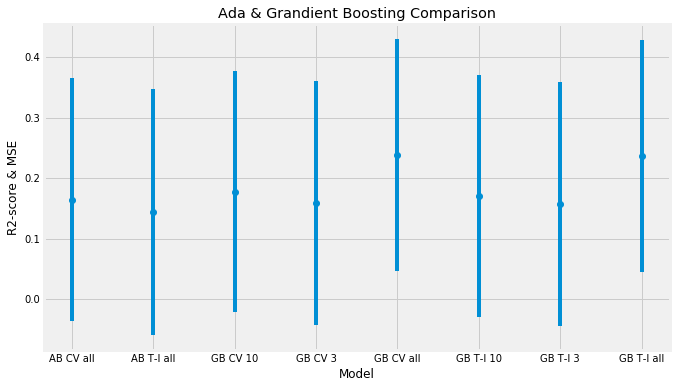

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['AB CV all','GB CV all', 'GB CV 10', 'GB CV 3', 'AB T-I all', 'GB T-I all', 'GB T-I 10', 'GB T-I 3'] # model name
y = [0.1647279913503793, 0.2384226323540044, 0.17780645284450913, 0.15909022715580334, 0.14338493550827192,
     0.2362633185213301, 0.1706690669450912, 0.15778723525858485] # r2-score
e = [0.20054058276262823, 0.19148965797661502, 0.19896438359756616, 0.2012162304182839, 0.20308655031893702,
     0.19176093283874088, 0.19982611316708965, 0.20137206261428192] #MSE

ax.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Ada & Grandient Boosting Comparison');
plt.show()

**Best from each Model-type**

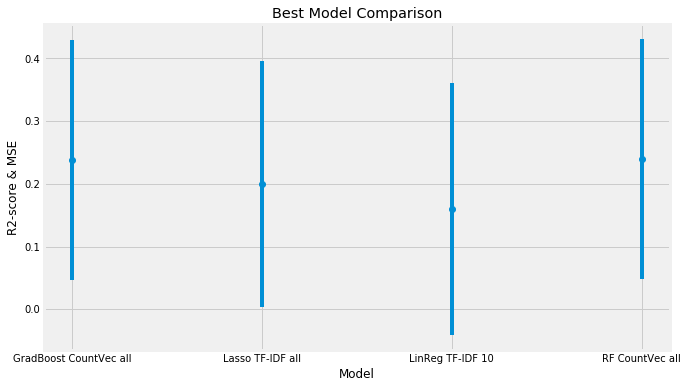

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

x = ['LinReg TF-IDF 10', 'Lasso TF-IDF all', 'RF CountVec all', 'GradBoost CountVec all'] # model name
y = [0.15924513606808388, 0.20023665642903288, 0.23981061254827155, 0.2384226323540044] # r2-score
e = [0.20119769595475592, 0.19623165025591427, 0.19131508276423695, 0.19148965797661502] #MSE

plt.errorbar(x, y, yerr=e, fmt='o')
plt.xlabel('Model');
plt.ylabel('R2-score & MSE');
plt.title('Best Model Comparison');
plt.show()